In [1]:
# Install necessary libraries
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install datasets
!pip install opencv-python-headless==4.5.4.60 fiftyone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sj8x2duy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sj8x2duy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=73c43e0ac096c1412b5afdc85e62ec26a9c69e863552ae658679e4463883ea1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-20i3hs1l/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset

# Load dataset
dataset = load_dataset("nlphuji/flickr30k")

# Define image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Custom Dataset Wrapper
class Flickr30KHFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']  # Replace with the correct key if different
        caption = item['caption']

        if self.transform:
            image = self.transform(image)

        return image, str(caption)

# Create Dataset and DataLoader
hf_train_dataset = Flickr30KHFDataset(dataset['test'], transform=transform)
train_loader = DataLoader(hf_train_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/641 [00:00<?, ?B/s]

flickr30k.py:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

0004.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

0005.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0006.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

0007.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

0008.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

In [3]:
import clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Convert model to float32
model = model.float()
tokenizer = clip.tokenize

# Example training loop
for images, captions in train_loader:
    images = images.to(device)
    text_tokens = tokenizer(captions, truncate=True).to(device)

    # Forward pass
    logits_per_image, logits_per_text = model(images, text_tokens)
    print(logits_per_image.shape, logits_per_text.shape)
    break



100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.2MiB/s]


torch.Size([32, 32]) torch.Size([32, 32])


In [4]:
from torch import nn, optim

# Define optimizer and loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, captions in train_loader:
        images = images.to(device)
        text_tokens = tokenizer(captions, truncate=True).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, text_tokens)
        targets = torch.arange(len(images)).to(device)  # Ground truth
        loss = (criterion(logits_per_image, targets) + criterion(logits_per_text, targets)) / 2

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.18116625376224527
Epoch 2, Loss: 0.15493019336436098
Epoch 3, Loss: 0.1459205508500952
Epoch 4, Loss: 0.13458401966892836
Epoch 5, Loss: 0.13078602874740364


In [5]:
# Evaluation loop
model.eval()
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for images, captions in train_loader:
        images = images.to(device)
        text_tokens = tokenizer(captions, truncate=True).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, text_tokens)
        preds = torch.argmax(logits_per_image, dim=1)

        correct += (preds == torch.arange(len(images)).to(device)).sum().item()
        total += len(images)

        targets = torch.arange(len(images)).to(device)  # 정답 인덱스

        loss = (criterion(logits_per_image, targets) + criterion(logits_per_text, targets)) / 2
        val_loss += loss.item()


val_loss /= len(train_loader)
print(f"Validation Loss: {val_loss}")


print(f"Validation Accuracy: {correct / total:.2%}")

Validation Loss: 0.1308528611762929
Validation Accuracy: 95.32%


In [6]:
import fiftyone as fo
import fiftyone.zoo as foz
from PIL import Image

# Download the COCO 2017 validation dataset
dataset = foz.load_zoo_dataset("coco-2017", split="validation")

class FiftyOneDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset, transform=None):
        self.samples = fiftyone_dataset
        self.transform = transform
        self.img_paths = self.samples.values("filepath")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        if sample.ground_truth is None or not hasattr(sample.ground_truth, 'detections'):
            caption = "No caption"
            detections = []
        else:
            detections = sample.ground_truth.detections
            caption = detections[0].label if detections else "No caption"

        # Load the image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, caption

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

# Create FiftyOne PyTorch Dataset and DataLoader
val_dataset = FiftyOneDataset(dataset, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [33.0s elapsed, 0s remaining, 26.8Mb/s]       


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [33.0s elapsed, 0s remaining, 26.8Mb/s]       


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading images to '/root/fiftyone/coco-2017/tmp-download/val2017.zip'


 100% |██████|    6.1Gb/6.1Gb [1.2m elapsed, 0s remaining, 115.9Mb/s]      


INFO:eta.core.utils: 100% |██████|    6.1Gb/6.1Gb [1.2m elapsed, 0s remaining, 115.9Mb/s]      


Extracting images to '/root/fiftyone/coco-2017/validation/data'


INFO:fiftyone.utils.coco:Extracting images to '/root/fiftyone/coco-2017/validation/data'


Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████| 5000/5000 [31.0s elapsed, 0s remaining, 205.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [31.0s elapsed, 0s remaining, 205.6 samples/s]      


Dataset 'coco-2017-validation' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation' created


In [7]:
model.eval()
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for images, captions in val_loader:
        images = images.to(device)
        text_tokens = tokenizer(captions, truncate=True).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, text_tokens)
        preds = torch.argmax(logits_per_image, dim=1)

        correct += (preds == torch.arange(len(images)).to(device)).sum().item()
        total += len(images)

        targets = torch.arange(len(images)).to(device)
        loss = (criterion(logits_per_image, targets) + criterion(logits_per_text, targets)) / 2
        val_loss += loss.item()

val_accuracy = correct / total
val_loss /= len(val_loader)

print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Validation Loss: {val_loss:.4f}")

Validation Accuracy: 39.76%
Validation Loss: 2.5561


In [8]:
model2, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Convert model to float32
model2 = model2.float()
tokenizer = clip.tokenize

optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.5)

epochs = 5
for epoch in range(epochs):
    model2.train()
    total_loss = 0

    for images, captions in train_loader:
        images = images.to(device)
        text_tokens = tokenizer(captions, truncate=True).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model2(images, text_tokens)
        targets = torch.arange(len(images)).to(device)  # Ground truth
        loss = (criterion(logits_per_image, targets) + criterion(logits_per_text, targets)) / 2

        # Backward pass
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
    scheduler.step()

Epoch 1, Loss: 0.28486597859828744
Epoch 2, Loss: 0.28404516859373713
Epoch 3, Loss: 0.2897173899955587
Epoch 4, Loss: 0.28930770243066795
Epoch 5, Loss: 0.2795484948711297


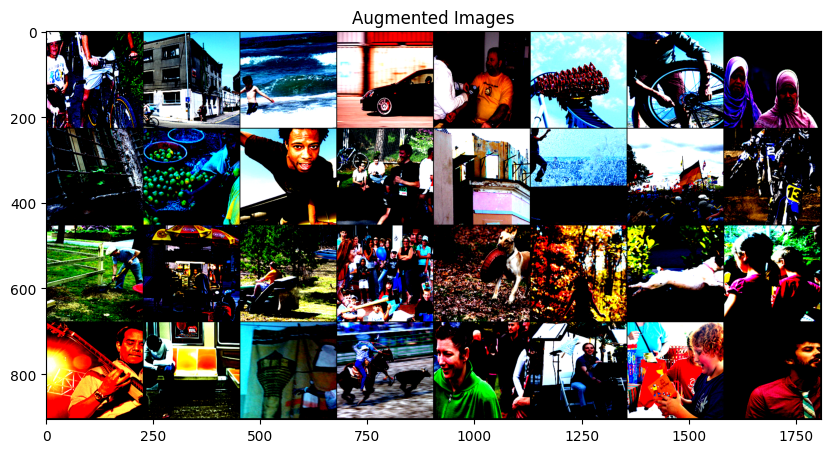

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Visualize augmented images
images, captions = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))  # Convert tensor to image format
plt.title("Augmented Images")
plt.show()

